# (SIMULATED) DATA FILE <br>

In [1]:
from fastkml import kml
import geopandas as gpd
import numpy as np
from shapely.geometry import shape
from shapely.geometry import Point
from shapely.geometry import Polygon
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from haversine import haversine, Unit
import contextily as ctx
import matplotlib.patches as patches

In [2]:
work = False  # this refers to the laptop I am using (work = True if I am using Kent Staff laptop; work = False if I am using my personal one)
if work:
    with open(r'C:/Users/ld514/OneDrive - University of Kent/PROJECTS/CUAMM - Ethiopia/model python/data/Gambella.kml', 'rb') as file:
        kml_content = file.read()
else:
    with open(r'C:/Users/laura/OneDrive - University of Kent/PROJECTS/CUAMM - Ethiopia/model python/data/Gambella.kml', 'rb') as file:
        kml_content = file.read()

# Parse the KML
k = kml.KML()
k.from_string(kml_content)

In [3]:
# Extract polygons
polygons = []
for feature in list(k.features()):
    for placemark in list(feature.features()):
        if placemark.geometry.geom_type == 'Polygon':
            polygons.append(shape(placemark.geometry))

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons)
gdf

,geometry
0,"POLYGON Z ((34.30777 8.33141 0, 34.30023 8.328..."
1,"POLYGON Z ((34.25668 8.30585 0, 34.24329 8.305..."
2,"POLYGON Z ((34.28042 8.28351 0, 34.26883 8.271..."
3,"POLYGON Z ((34.7205 8.15002 0, 34.72211 8.1367..."
4,"POLYGON Z ((34.42645 7.75125 0, 34.42463 7.749..."
5,"POLYGON Z ((34.14901 7.93115 0, 34.1365 7.9268..."
6,"POLYGON Z ((35.13326 6.44677 0, 35.13097 6.445..."


In [ ]:
# Save to a shapefile or any other format if needed
#gdf.to_file("polygons.shp")

# Save as CSV (with WKT for geometries)
# gdf.to_csv("polygons.csv", index=False)

In [4]:
def generate_points_within_polygon(polygon, n_points=100):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < n_points:
        p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(p):
            points.append((p.x, p.y))
    return np.array(points)

In [5]:
def cluster_polygon(polygon, n_clusters):
    # Generate points within the polygon
    points = generate_points_within_polygon(polygon)
    
    # Handle cases with fewer points than the number of clusters
    if len(points) < n_clusters:
        print(f"Polygon with {len(points)} points cannot be clustered into {n_clusters} clusters.")
        return None, None

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
    
    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_
    return points, centroids, kmeans.labels_

In [6]:
# Example usage
n_clusters = [5,3,4,3,1,3,1]  # Number of clusters (population zones) desired
results = []

for idx, row in gdf.iterrows():
    polygon = row['geometry']
    points, centroids, labels = cluster_polygon(polygon, n_clusters[idx])
    
    if centroids is not None:
        results.append({
            'polygon': polygon,
            'points': points,
            'centroids': centroids,
            'labels': labels
        })

results

c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\laura\anaconda3\envs\gambella_refcamps\Lib\site-packages\s

[{'polygon': <POLYGON Z ((34.308 8.331 0, 34.3 8.329 0, 34.303 8.325 0, 34.306 8.326 0, 3...>,
  'points': array([[34.31513346,  8.31652187],
         [34.33711259,  8.2964075 ],
         [34.33083559,  8.29371527],
         [34.33546129,  8.29157105],
         [34.3115564 ,  8.32586824],
         [34.31973667,  8.32791753],
         [34.31928719,  8.3184797 ],
         [34.32134659,  8.3096099 ],
         [34.33452151,  8.29143153],
         [34.31393997,  8.31505463],
         [34.31317507,  8.32971912],
         [34.33797879,  8.29600027],
         [34.33013409,  8.30113349],
         [34.31833532,  8.32986298],
         [34.31835379,  8.30806431],
         [34.33096737,  8.291821  ],
         [34.3231352 ,  8.30278185],
         [34.31310548,  8.31265221],
         [34.30742422,  8.33106473],
         [34.31279778,  8.32181457],
         [34.32529445,  8.3171162 ],
         [34.3176363 ,  8.3187607 ],
         [34.31214665,  8.31804972],
         [34.31937529,  8.31338757],
       

In [7]:
def plot_clustering_results(polygon, points, centroids, labels, title):
    """
    Visualize clustering results with an optional title.
    
    Parameters:
        polygon: Shapely polygon object representing the boundary.
        points: Array of clustered points (NumPy array).
        centroids: Array of centroids (NumPy array).
        labels: Cluster labels for the points.
        title: Title for the plot.
    """
    plt.figure()
    plt.title(title)

    # Plot the polygon
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='black', linestyle='-', linewidth=1, label='Polygon')
    
    # Plot the clustered points
    scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', label='Clustered Points')
    plt.colorbar(scatter, label='Cluster ID')
    
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
    
    plt.legend()
    plt.show()

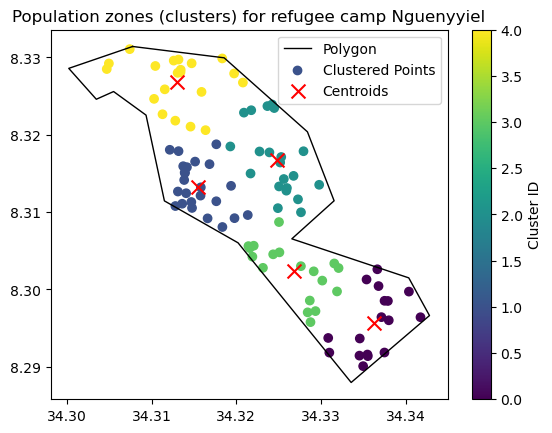

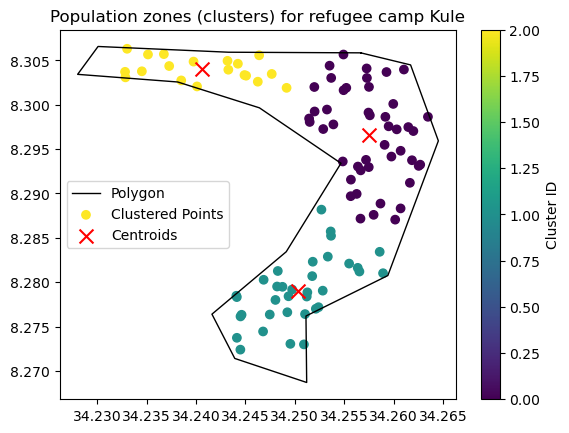

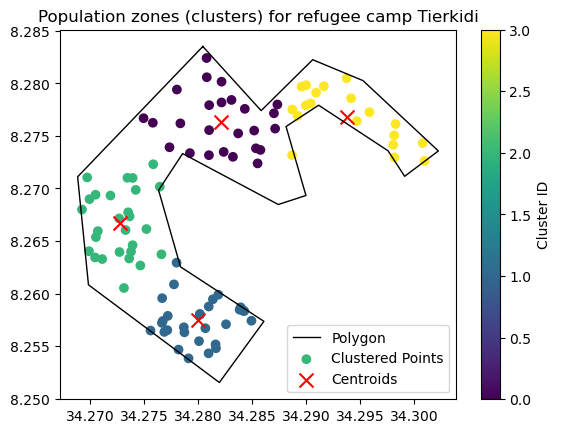

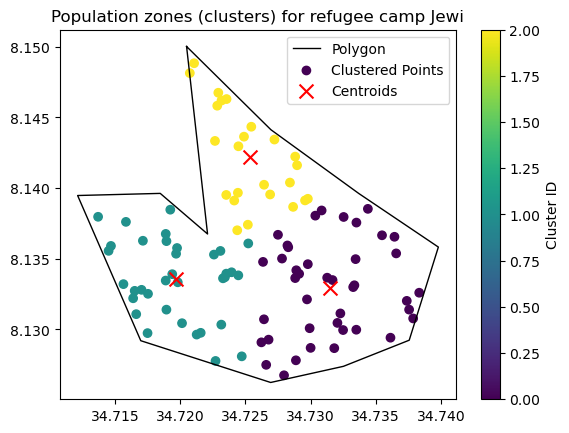

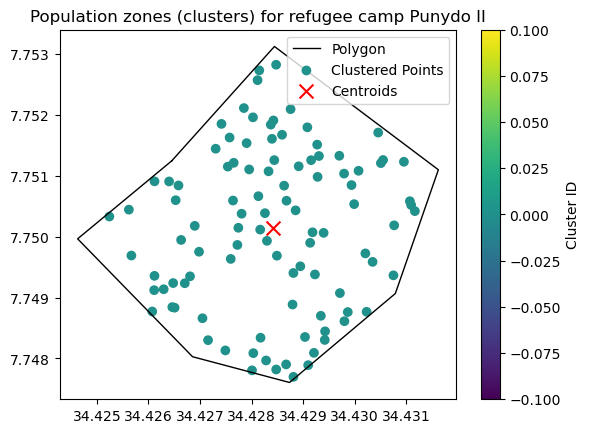

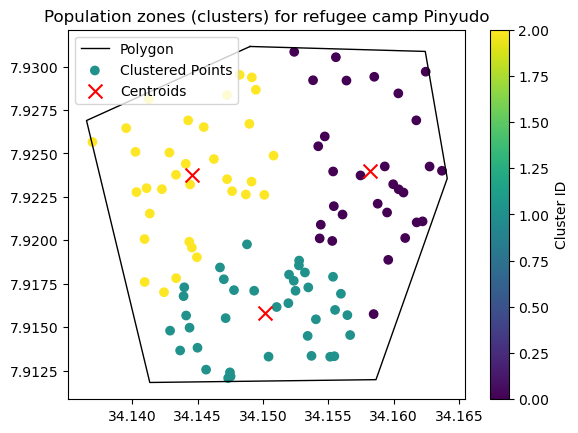

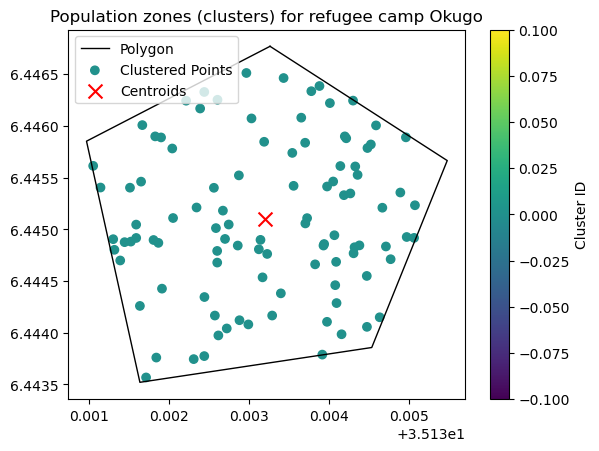

In [8]:
# Plot the results for the different polygon: 
if results:
    for i, result in enumerate(results):
        camps_names = ['Nguenyyiel', 'Kule', 'Tierkidi', 'Jewi', 'Punydo II','Pinyudo', 'Okugo']  # Camp names
        
        # Use camp names for titles
        title = f"Population zones (clusters) for refugee camp {camps_names[i]}"
        
        # Plot the results for the current polygon
        plot_clustering_results(
            result['polygon'], 
            result['points'], 
            result['centroids'], 
            result['labels'],
            title=title
        )


In [9]:
# Initialize an empty list to hold all centroids
all_centroids = []

# Iterate over each entry in the results
for index in range(len(results)):
    # Extract the centroids for the current index
    centroids = results[index]['centroids']
    
    # Append the centroids to the list
    all_centroids.extend(centroids.tolist())  # Convert array to list and extend


In [10]:
population_zones = all_centroids
population_names = ['Nguenyyiel 1', 'Nguenyyiel 2', 'Nguenyyiel 3', 'Nguenyyiel 4', 'Nguenyyiel 5',
               'Kule 1', 'Kule 2', 'Kule 3', 
               'Tierkidi 1', 'Tierkidi 2', 'Tierkidi 3', 'Tierkidi 4', 
               'Jewi 1', 'Jewi 2', 'Jewi 3', 'Pinyudo-II 1',
                'Pinyudo 1', 'Pinyudo 2', 'Pinyudo 3',
                'Okugo 1']
gambella_hospital = np.array([[34.580385,8.242747699999999]])
all_zones = population_zones
all_zones.extend(gambella_hospital.tolist()) 
all_names = population_names
all_names.append('Gambella-Hospital')
"""
Note the order of the refugee camps is: Nguenyyiel, Kule, Tierkidi, Jewi, Pinyudo-II, Pinyudo, Okugo
"""

'\nNote the order of the refugee camps is: Nguenyyiel, Kule, Tierkidi, Jewi, Pinyudo-II, Pinyudo, Okugo\n'

In [ ]:
# # This was added on 27 Feb 2025 just to create a pandas dataframe that Power BI could use

# # Assuming all_zones is a list of [Longitude, Latitude] pairs
# # and all_names is the corresponding list of names:
# df_zones = pd.DataFrame(all_zones, columns=['Longitude', 'Latitude'])
# df_zones['Name'] = all_names

# # This DataFrame is what Power BI will capture.
# dataset_camps = df_zones
# dataset_camps
# print(df_zones.head())

# # Explicitly convert to float (if not already)
# df_zones['Longitude'] = df_zones['Longitude'].astype(float)
# df_zones['Latitude'] = df_zones['Latitude'].astype(float)


# # This is the DataFrame Power BI will capture
# dataset = df_zones

# print(df_zones)
# print(df_zones.dtypes)
# df_zones

   Longitude  Latitude          Name
0  34.317376  8.316699  Nguenyyiel 1
1  34.328620  8.300211  Nguenyyiel 2
2  34.310923  8.327147  Nguenyyiel 3
3  34.325274  8.308510  Nguenyyiel 4
4  34.335592  8.295086  Nguenyyiel 5
    Longitude  Latitude               Name
0   34.317376  8.316699       Nguenyyiel 1
1   34.328620  8.300211       Nguenyyiel 2
2   34.310923  8.327147       Nguenyyiel 3
3   34.325274  8.308510       Nguenyyiel 4
4   34.335592  8.295086       Nguenyyiel 5
5   34.257636  8.296292             Kule 1
6   34.251260  8.279067             Kule 2
7   34.241139  8.303867             Kule 3
8   34.273383  8.268584         Tierkidi 1
9   34.282152  8.275221         Tierkidi 2
10  34.294951  8.276792         Tierkidi 3
11  34.278411  8.258632         Tierkidi 4
12  34.720909  8.132891             Jewi 1
13  34.726274  8.141576             Jewi 2
14  34.734096  8.133916             Jewi 3
15  34.428233  7.749958       Pinyudo-II 1
16  34.149728  7.926423          Pinyudo 1
17  

,Longitude,Latitude,Name
0,34.317376,8.316699,Nguenyyiel 1
1,34.328620,8.300211,Nguenyyiel 2
2,34.310923,8.327147,Nguenyyiel 3
3,34.325274,8.308510,Nguenyyiel 4
4,34.335592,8.295086,Nguenyyiel 5
5,34.257636,8.296292,Kule 1
6,34.251260,8.279067,Kule 2
7,34.241139,8.303867,Kule 3
8,34.273383,8.268584,Tierkidi 1
9,34.282152,8.275221,Tierkidi 2


In [ ]:
# I created a geojson file with the above coordinates of refugee camps' population zones as a base geojson file. Then, I manually include the coordinates of the candidate locations generated in the next cell

# import json

# # Create a DataFrame with your coordinates and names
# data = {
#     'Longitude': [34.334799, 34.315748, 34.328889, 34.313471, 34.324820, 
#                   34.250268, 34.248375, 34.259921, 34.276707, 34.280388, 
#                   34.272994, 34.292617, 34.721450, 34.733586, 34.724051, 
#                   34.428196, 34.153949, 34.142925, 34.156337],
#     'Latitude':  [8.295230, 8.315304, 8.302752, 8.325816, 8.314669, 
#                   8.278794, 8.302462, 8.293360, 8.260158, 8.275491, 
#                   8.270714, 8.276422, 8.132619, 8.134171, 8.143258, 
#                   7.750127, 7.917223, 7.921820, 7.926163],
#     'Name': [
#         'Nguenyyiel 1', 'Nguenyyiel 2', 'Nguenyyiel 3', 'Nguenyyiel 4', 'Nguenyyiel 5',
#         'Kule 1', 'Kule 2', 'Kule 3',
#         'Tierkidi 1', 'Tierkidi 2', 'Tierkidi 3', 'Tierkidi 4',
#         'Jewi 1', 'Jewi 2', 'Jewi 3',
#         'Pinyudo-II 1', 'Pinyudo 1', 'Pinyudo 2', 'Pinyudo 3'
#     ]
# }

# df = pd.DataFrame(data)

# # Create a list of GeoJSON features
# features = []
# for _, row in df.iterrows():
#     feature = {
#         "type": "Feature",
#         "properties": {
#             "Name": row["Name"]
#             # Optionally, add other properties here (e.g., "type_f": "demand_point")
#         },
#         "geometry": {
#             "type": "Point",
#             "coordinates": [row["Longitude"], row["Latitude"]]
#         }
#     }
#     features.append(feature)

# # Build the complete GeoJSON structure
# geojson = {
#     "type": "FeatureCollection",
#     "name": "location_nodes",
#     "features": features
# }

# # Write the GeoJSON to a file
# with open("new_location_nodes.geojson", "w") as f:
#     json.dump(geojson, f, indent=4)

# print("GeoJSON file created successfully.")


GeoJSON file created successfully.


In [ ]:
# df_zones_new = df_zones[:-2]
# df_zones_new

,Longitude,Latitude,Name
0,34.317376,8.316699,Nguenyyiel 1
1,34.328620,8.300211,Nguenyyiel 2
2,34.310923,8.327147,Nguenyyiel 3
3,34.325274,8.308510,Nguenyyiel 4
4,34.335592,8.295086,Nguenyyiel 5
5,34.257636,8.296292,Kule 1
6,34.251260,8.279067,Kule 2
7,34.241139,8.303867,Kule 3
8,34.273383,8.268584,Tierkidi 1
9,34.282152,8.275221,Tierkidi 2


In [58]:
# Given coordinates for zones
df_zones_new

# Define a function to generate nearby candidate locations
def generate_candidates(df, num_points, jitter=0.005):
    np.random.seed(42)  # Ensure reproducibility
    candidates = df.sample(n=num_points, replace=True).copy()  # Sample existing locations as base
    candidates["Longitude"] += np.random.uniform(-jitter, jitter, num_points)
    candidates["Latitude"] += np.random.uniform(-jitter, jitter, num_points)
    return candidates.reset_index(drop=True)

# Generate 8 candidate locations for HPS and 5 for HCS
candidate_hps = generate_candidates(df_zones_new, 8)
candidate_hcs = generate_candidates(df_zones_new, 5)

# Select 3 common locations and replace in both sets
common_candidates = generate_candidates(df_zones_new, 3)

candidate_hps.iloc[:3] = common_candidates.iloc[:3].values
candidate_hcs.iloc[:3] = common_candidates.iloc[:3].values

# Assign names to candidate locations
candidate_hps["Name"] = [f"HP_CandidateLocation{i+1}" for i in range(len(candidate_hps))]
candidate_hcs["Name"] = [f"HC_CandidateLocation{i+1}" for i in range(len(candidate_hcs))]

# Combine into one DataFrame for reference
candidates_df = pd.concat([candidate_hps.assign(type_f="HP"), candidate_hcs.assign(type_f="HC")], ignore_index=True)
candidates_df


,Longitude,Latitude,Name,type_f
0,34.251172,8.298461,HP_CandidateLocation1,HP
1,34.725020,8.142850,HP_CandidateLocation2,HP
2,34.272452,8.269051,HP_CandidateLocation3,HP
3,34.255127,8.292679,HP_CandidateLocation4,HP
4,34.253074,8.300374,HP_CandidateLocation5,HP
5,34.159662,7.927281,HP_CandidateLocation6,HP
6,34.270117,8.267109,HP_CandidateLocation7,HP
7,34.269812,8.268636,HP_CandidateLocation8,HP
8,34.251172,8.298461,HC_CandidateLocation1,HC
9,34.725020,8.142850,HC_CandidateLocation2,HC


In [11]:
# Calculate the Haversine distance matrix (again, I used the Haversine distance for illustrative purposes, but probably CUAMM
# has real data on distances, based on the transportation network in Ethiopia)
def get_dist_matrix(all_zones, all_names):
    dist_matrix = []
    for i in range(len(all_zones)):
        row = []
        for j in range(len(all_zones)):
            distance = haversine(all_zones[i], all_zones[j], unit=Unit.KILOMETERS) 
            row.append(distance)
        dist_matrix.append(row)

    # Creating a DataFrame for the distance matrix
    dist_df = pd.DataFrame(dist_matrix, index=all_names, columns=all_names)
    return dist_matrix, dist_df


# Calculate the distance matrix with the above function and data
# distance_matrix = get_dist_matrix(all_zones, all_names)[1]
distance_matrix = get_dist_matrix(all_zones[:-2], all_names[:-2])[1]
distance_matrix

,Nguenyyiel 1,Nguenyyiel 2,Nguenyyiel 3,Nguenyyiel 4,Nguenyyiel 5,Kule 1,Kule 2,Kule 3,Tierkidi 1,Tierkidi 2,Tierkidi 3,Tierkidi 4,Jewi 1,Jewi 2,Jewi 3,Pinyudo-II 1,Pinyudo 1,Pinyudo 2,Pinyudo 3
Nguenyyiel 1,0.000000,1.309879,1.333761,2.109619,2.252492,7.438094,8.416995,9.500112,7.048971,5.797195,4.599279,6.878566,47.110042,48.495973,47.638538,53.004184,41.397910,40.175425,40.730356
Nguenyyiel 2,1.309879,0.000000,2.640479,3.374805,0.974397,8.059244,8.829576,10.216003,6.852648,5.901839,4.509518,6.942892,46.038659,47.432576,46.578359,51.791853,40.817621,39.577803,40.167904
Nguenyyiel 3,1.333761,2.640479,0.000000,0.869997,3.585367,6.878740,8.063907,8.793206,7.361305,5.863015,4.932348,6.938380,48.280282,49.659302,48.799354,54.189828,41.905257,40.701818,41.219812
Nguenyyiel 4,2.109619,3.374805,0.869997,0.000000,4.342628,6.193527,7.471376,8.029281,7.174071,5.551064,4.822644,6.598930,49.145407,50.525356,49.665705,54.612392,41.744926,40.555328,41.047537
Nguenyyiel 5,2.252492,0.974397,3.585367,4.342628,0.000000,8.845941,9.506775,11.033849,7.184339,6.448721,4.981869,7.444351,45.103958,46.500792,45.647864,51.070452,40.725186,39.471679,40.090690
Kule 1,7.438094,8.059244,6.878740,6.193527,8.845941,0.000000,1.666243,2.237845,4.716433,3.360465,4.603031,3.335883,53.599841,55.018244,54.176256,53.775971,37.176214,36.067432,36.421922
Kule 2,8.416995,8.829576,8.063907,7.471376,9.506775,1.666243,0.000000,2.672709,3.982668,3.264632,4.753618,2.703977,53.733012,55.163242,54.329279,52.526974,35.510213,34.402492,34.755688
Kule 3,9.500112,10.216003,8.793206,8.029281,11.033849,2.237845,2.672709,0.000000,6.579235,5.493590,6.817757,5.229896,55.837188,57.255879,56.414006,55.118735,37.088336,36.030761,36.305298
Tierkidi 1,7.048971,6.852648,7.361305,7.174071,7.184339,4.716433,3.982668,6.579235,0.000000,1.837042,2.456146,1.381475,50.041652,51.481773,50.656170,49.202195,34.572118,33.381259,33.877620
Tierkidi 2,5.797195,5.901839,5.863015,5.551064,6.448721,3.360465,3.264632,5.493590,1.837042,0.000000,1.513759,1.084735,50.486676,51.914567,51.078980,50.938091,36.239416,35.063508,35.532184


In [12]:
import json
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

def calculate_euclidean_distances(geojson_file):
    # Load GeoJSON file
    with open(geojson_file, "r") as file:
        geo_data = json.load(file)
    
    # Initialize type counters
    #type_counter = {}
    coordinates = []
    point_names = []

    # Extract coordinates and use "id" field for naming 
    for feature in geo_data['features']:
        coords = feature['geometry']['coordinates']
        point_id = feature['properties']['id']

        """
        # Initialize counter for new types
        if point_type not in type_counter:
            type_counter[point_type] = 0
        
        # Increment the counter and create the unique name
        type_counter[point_type] += 1
        point_name = f"{point_type}_{type_counter[point_type]}"  # E.g., HP1, HC1, etc.
        """
        
        # Store coordinates and the 'id' as the name
        coordinates.append(coords)
        point_names.append(point_id)
    
    # Convert coordinates to a NumPy array
    coordinates_array = np.array(coordinates)
    
    # Use scipy's cdist function to compute the Euclidean distance matrix
    distance_matrix = cdist(coordinates_array, coordinates_array, metric='euclidean')
    
    # Create a labeled DataFrame
    distance_df = pd.DataFrame(distance_matrix, index=point_names, columns=point_names)
    
    return distance_df

In [ ]:
# Example usage with your GeoJSON file
# import os
# geojson_file = os.path.join("..","location_refcamps.geojson")
# distance_df = calculate_euclidean_distances(geojson_file)

# # Save the distance matrix as a CSV (optional)
# distance_df.to_csv("distance_matrix_refcamps.csv")

# # Print the DataFrame for inspection
# distance_df.round(2)

,dp1,dp2,dp3,dp4,dp5,dp6,dp7,dp8,dp9,dp10,...,hp4,hp5,hp6,hp7,hp8,hc1,hc2,hc3,hc4,hc5
dp1,0.00,0.03,0.01,0.04,0.02,0.09,0.09,0.07,0.07,0.06,...,0.08,0.08,0.41,0.07,0.07,0.08,0.42,0.07,0.08,0.09
dp2,0.03,0.00,0.02,0.01,0.01,0.07,0.07,0.06,0.07,0.05,...,0.06,0.06,0.42,0.07,0.07,0.07,0.44,0.06,0.06,0.07
dp3,0.01,0.02,0.00,0.03,0.01,0.08,0.08,0.07,0.07,0.06,...,0.07,0.08,0.41,0.07,0.07,0.08,0.43,0.07,0.07,0.08
dp4,0.04,0.01,0.03,0.00,0.02,0.08,0.07,0.06,0.08,0.06,...,0.07,0.07,0.43,0.07,0.07,0.07,0.45,0.07,0.06,0.07
dp5,0.02,0.01,0.01,0.02,0.00,0.08,0.08,0.07,0.07,0.06,...,0.07,0.07,0.42,0.07,0.07,0.08,0.44,0.07,0.07,0.08
dp6,0.09,0.07,0.08,0.08,0.08,0.00,0.02,0.02,0.03,0.03,...,0.01,0.02,0.36,0.02,0.02,0.02,0.49,0.02,0.02,0.02
dp7,0.09,0.07,0.08,0.07,0.08,0.02,0.00,0.01,0.05,0.04,...,0.01,0.01,0.39,0.04,0.04,0.00,0.50,0.04,0.01,0.01
dp8,0.07,0.06,0.07,0.06,0.07,0.02,0.01,0.00,0.04,0.03,...,0.00,0.01,0.38,0.03,0.03,0.01,0.49,0.03,0.00,0.02
dp9,0.07,0.07,0.07,0.08,0.07,0.03,0.05,0.04,0.00,0.02,...,0.04,0.05,0.35,0.01,0.01,0.05,0.46,0.01,0.04,0.05
dp10,0.06,0.05,0.06,0.06,0.06,0.03,0.04,0.03,0.02,0.00,...,0.03,0.04,0.37,0.01,0.01,0.04,0.46,0.01,0.03,0.04


In [19]:
# Convert to GeoDataFrame
geometry_popzones = [Point(xy) for xy in all_zones]
gdf_popzones = gpd.GeoDataFrame(geometry=geometry_popzones)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf_popzones.set_crs(epsg=4326, inplace=True)

# Convert the GeoDataFrame to the Web Mercator projection (EPSG:3857)
gdf_popzones = gdf_popzones.to_crs(epsg=3857)
gdf_popzones

,geometry
0,POINT (3820192.849 929079.049)
1,POINT (3821444.53 927224.144)
2,POINT (3819474.476 930254.453)
3,POINT (3821071.967 928157.747)
4,POINT (3822220.669 926647.611)
5,POINT (3813542.629 926783.279)
6,POINT (3812832.796 924845.566)
7,POINT (3811706.19 927635.348)
8,POINT (3815295.529 923666.234)
9,POINT (3816271.709 924412.833)


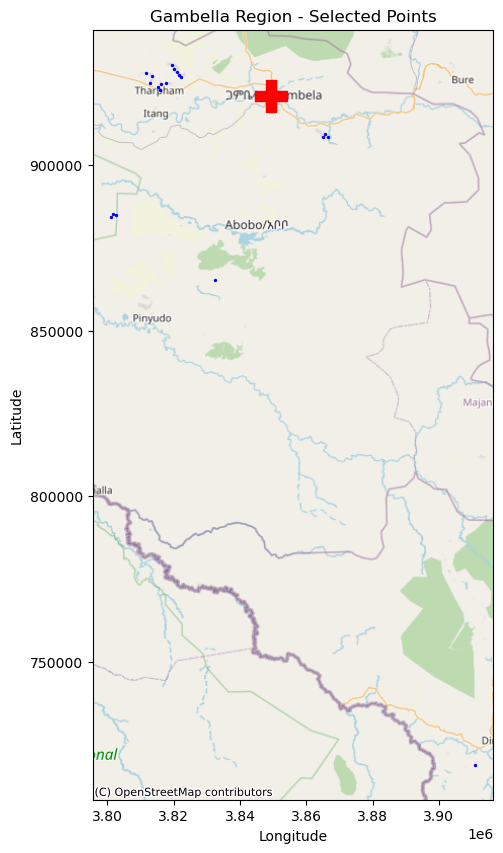

In [20]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))


# Plot all points except the last one
gdf_popzones.iloc[:-1].plot(ax=ax, color='blue', markersize=2)


# Plot the last point with a custom "doctor's cross" marker
last_point = gdf_popzones.iloc[-1]


# Define the doctor's cross marker (red cross)
marker_cross = plt.Line2D((0,1),(0,0), color='red', lw=5) # Use Line2D to create a cross marker


ax.scatter(last_point.geometry.x, last_point.geometry.y, s=500, color='red', marker='P')


# Add basemap from contextily using OpenStreetMap
ctx.add_basemap(ax, crs=gdf_popzones.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)


# Set axis labels and title
ax.set_title('Gambella Region - Selected Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


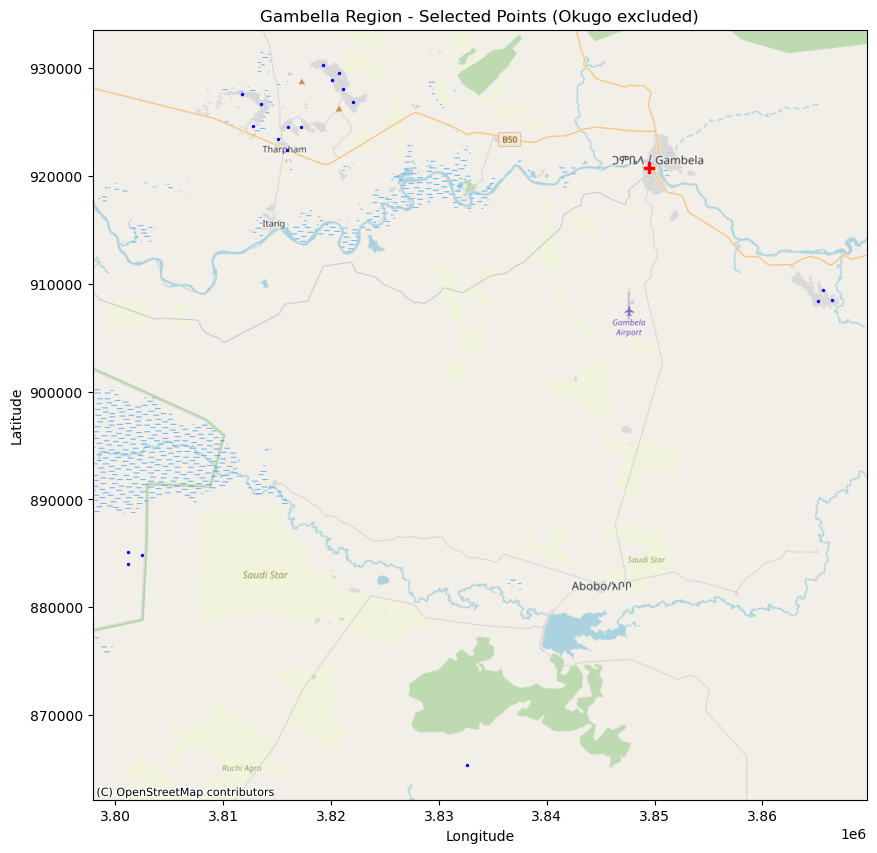

In [ ]:
#If I want to disregard Okugo:

# Exclude the one but last point
gdf_popzones_filtered = gdf_popzones.drop(gdf_popzones.index[-2])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all points except the last one
gdf_popzones_filtered.iloc[:-1].plot(ax=ax, color='blue', markersize=2)

# Plot the last point with a custom "doctor's cross" marker
last_point = gdf_popzones_filtered.iloc[-1]

# Coordinates for the last point
x, y = last_point.geometry.x, last_point.geometry.y

# Create the doctor's cross as a combination of two rectangles
cross_size = 1000  # Adjust size of the cross here
cross_width = cross_size / 5  # Adjust width of the cross arms here

# Create horizontal and vertical bars for the cross
horizontal_bar = patches.Rectangle((x - cross_size / 2, y - cross_width / 2), cross_size, cross_width, color='red')
vertical_bar = patches.Rectangle((x - cross_width / 2, y - cross_size / 2), cross_width, cross_size, color='red')

# Add the bars to the plot
ax.add_patch(horizontal_bar)
ax.add_patch(vertical_bar)

# Add basemap from contextily using OpenStreetMap
ctx.add_basemap(ax, crs=gdf_popzones.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set axis labels and title
ax.set_title('Gambella Region - Selected Points (Okugo excluded)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [ ]:
# Note the order of the refugee camps is: Nguenyyiel, Kule, Tierkidi, Jewi, Pinyudo-II, Pinyudo, Okugo (the one in population_zones)

# The population of each refugee camp is:
d = np.array([112000, 52959, 72438, 67896, 11392, 51239, 13954])

# Create the repeated vector
repeated_demand = np.repeat(d, n_clusters)
repeated_clusters = np.repeat(n_clusters, n_clusters)

# We uniformly distribute the demand of each refugee camp over each of the population zones within each refugee camp
demand_per_population_zone = repeated_demand/repeated_clusters


In [ ]:
# Now, for each of the specialities, we calculate the demand per population zone
basic_care_demand = np.ceil(demand_per_population_zone)
fertility_rate = 0.035
maternal_demand = np.ceil(demand_per_population_zone*fertility_rate)
under18_rate = 0.66
pediatric_demand = np.ceil(demand_per_population_zone*under18_rate)
tachioma_rate = 0.172
eyecare_demand = np.ceil(demand_per_population_zone*tachioma_rate)

# Create the DataFrame
data = {
    'Basic Care': basic_care_demand,
    'Maternal Care': maternal_demand,
    'Pediatric Care': pediatric_demand,
    'Eye Care': eyecare_demand
}

demand = pd.DataFrame(data)

# Display the DataFrame
print(demand)

    Basic Care  Maternal Care  Pediatric Care  Eye Care
0      22400.0          785.0         14784.0    3853.0
1      22400.0          785.0         14784.0    3853.0
2      22400.0          785.0         14784.0    3853.0
3      22400.0          785.0         14784.0    3853.0
4      22400.0          785.0         14784.0    3853.0
5      17653.0          618.0         11651.0    3037.0
6      17653.0          618.0         11651.0    3037.0
7      17653.0          618.0         11651.0    3037.0
8      18110.0          634.0         11953.0    3115.0
9      18110.0          634.0         11953.0    3115.0
10     18110.0          634.0         11953.0    3115.0
11     18110.0          634.0         11953.0    3115.0
12     22632.0          793.0         14938.0    3893.0
13     22632.0          793.0         14938.0    3893.0
14     22632.0          793.0         14938.0    3893.0
15     11392.0          399.0          7519.0    1960.0
16     17080.0          598.0         11273.0   

In [ ]:
"""
In each HP we need to have:
- Basic care: between 10 and 20 supportive staff
- Maternal: between 1 and 2 midwives
- Pediatric: between 2 and 5 nurses
- Eye care: no more than 2 professionals

In each HC we need to have: 
- Basic care: between 20 and 30 supportive staff
- Maternal: between 2 and 5 midwives
- Pediatric: between 4 and 8 nurses
- Eye care: between 1 and 4 professionals

At the hospital we need to have:
- Basic care: more than 50 supportive staff
- Maternal: more than 5 midwives
- Pediatric: between 6 and 12 nurses
- Eye care: between 3 and 6 professionals
"""

lb_specialists_HPs = [10, 1, 2, 0] 
ub_specialists_HPs = [20, 2, 5, 2]
lb_specialists_HCs = [20, 2, 4, 1]
ub_specialists_HCs = [30, 5, 8, 4]
lb_specialists_Hosp = [50, 5, 6, 3]
ub_specialists_Hosp = [1000, 1000, 12, 6]


# Combine the lists into a 2D matrix
lb_specialists = np.array([lb_specialists_HPs, lb_specialists_HCs, lb_specialists_Hosp])
ub_specialists = np.array([ub_specialists_HPs, ub_specialists_HCs, ub_specialists_Hosp])

# The number of specialists to locate (per 'level of service') is s_l
s_l = [197, 14, 19, 12]


In [ ]:
# Service rates for each professional (to define somehow the capacity of the system)
# rates expressed in patients/day per professional
rates_specialists_HPs = [42, 28, 28, 42]
rates_specialists_HCs = [42, 10, 28, 14]
rates_specialists_Hosp = [42, 4, 28, 14]

rates_specialists = np.array([rates_specialists_HPs, rates_specialists_HCs, rates_specialists_Hosp])

In [ ]:
facilities_to_locate = [4,2,1]
rates_referrals = np.array([[0,0.1,0], [0,0,0.3], [0,0,0]])


In [ ]:
# Function to get camps within a specified distance

def within_distance(camps_coord, camps_names, max_distance):
    distance_matrix = get_dist_matrix(camps_coord, camps_names)[1]
    camps_within_distance = {}
    for i in camps_names:
        within_distance_aux = distance_matrix[i][distance_matrix[i] <= max_distance].index.tolist()
        within_distance_aux.remove(i)  # Remove the camp itself from the list
        camps_within_distance[i] = within_distance_aux
    # Create a mapping from names to indices
    name_to_index = {name: index + 1 for index, name in enumerate(camps_within_distance.keys())}
    # Create a new dictionary with indices
    indexed_dict = {name_to_index[key]: [name_to_index[neighbor] for neighbor in neighbors]
                for key, neighbors in camps_within_distance.items()}
    return camps_within_distance, indexed_dict

zones_within_d1  = within_distance(all_zones, all_names, max_distance=50)[0]
#zones_within_d1
facilities_within_d2  = within_distance(all_zones, all_names, max_distance=100)[0]
#facilities_within_d2
indexed_dict_zones = within_distance(all_zones, all_names, max_distance=50)[1]
#indexed_dict_zones
indexed_dict_facilities = within_distance(all_zones, all_names, max_distance=100)[1]
#indexed_dict_facilities

d_dict = {index + 1: value for index, value in enumerate(d)}
d_dict

{1: np.int64(112000),
 2: np.int64(52959),
 3: np.int64(72438),
 4: np.int64(67896),
 5: np.int64(11392),
 6: np.int64(51239),
 7: np.int64(13954)}